<a href="https://colab.research.google.com/github/huongnd12/traffic-sign-detection/blob/main/traffic_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Traffic sign classifier

Dataset contains 877 images with 4 classes (`trafficlight`, `stop`, `speedlimit`, `crosswalk`)
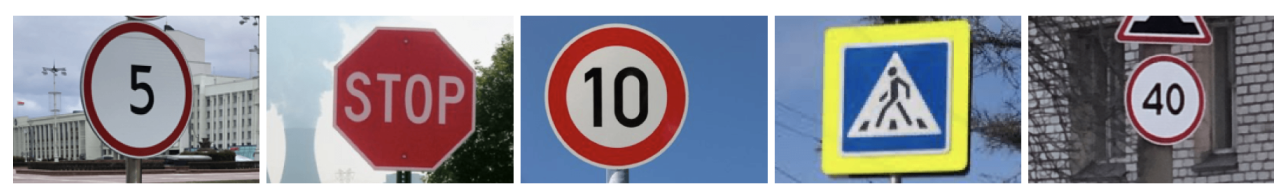

## 1.1. Import libraries

In [ ]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET    # ElementTree provides a simple way to build XML documents and write them to files

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 1.2. Read data

In [ ]:
!gdown 10tCUgVgMDZGdtH2ju0T-o2R8teHb9onv
!unzip traffic_sign_detection.zip

After unzip input data, I got 2 folders:
- `images`: contains image files
- `annotations`: contains .xml files which are information about coordinates and classes of objects in images in the `images` folder respectively

Next, I'll read image files and their labels into 2 separate lists. As this project focuses on the detection of traffic sign, I will not consider `trafficlight` data.
- `img_ls`: contains traffic sign object images
- `label_ls`: contains corresponding class name of object in `img_ls`

In [ ]:
annotation_dir = '/content/annotations'
img_dir = '/content/images'

img_ls = []
label_ls = []

In [ ]:
for xml_file in os.listdir(annotation_dir):
  xml_path = os.path.join(annotation_dir, xml_file)
  tree = ET.parse(xml_path)
  root = tree.getroot()
  filename = root.find('filename').text
  img_path = os.path.join(img_dir, filename)

  for obj in root.findall('object'):
    class_name = obj.find('name').text
    xmin = int(obj.find('bndbox/xmin').text)
    ymin = int(obj.find('bndbox/ymin').text)
    xmax = int(obj.find('bndbox/xmax').text)
    ymax = int(obj.find('bndbox/ymax').text)

    img = cv2.imread(img_path)
    object_img = img[ymin:ymax, xmin:xmax]

    if class_name != 'trafficlight':
      img_ls.append(object_img)
      label_ls.append(class_name)

In [ ]:
print('Number of objects:', len(img_ls))
print('Class names:', list(set(label_ls)))

Number of objects: 1074
Class names: ['stop', 'speedlimit', 'crosswalk']


## 1.3. Image preprocessing

- Convert to grayscale images
- Resize images to the same size
- Use HOG to represent better feature for images

In [ ]:
def preprocess_img(img):
  if len(img.shape) > 2:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  img = img.astype(np.float32)
  resized_img = resize(img,
                        output_shape=(32,32),
                        anti_aliasing=True
                        )

  hog_feature = feature.hog(resized_img,
                            orientations=9,
                            pixels_per_cell=(8,8),
                            cells_per_block=(2,2),
                            block_norm='L2',
                            feature_vector=True)

  return hog_feature


In [ ]:
hog_feature_ls = []
for img in img_ls:
  hog_f = preprocess_img(img)
  hog_feature_ls.append(hog_f)

In [ ]:
print('Shape of an image before preprocessing:', img_ls[0].shape)
print('Shape of an image after preprocessing:', hog_feature_ls[0].shape)

Shape of an image before preprocessing: (59, 59, 3)
Shape of an image after preprocessing: (324,)


In [ ]:
img_features = np.array(hog_feature_ls)

In [ ]:
img_features.shape

(1074, 324)

## 1.4. Label Encoding

In [ ]:
encoder = LabelEncoder()
encoded_label = encoder.fit_transform(label_ls)

In [ ]:
encoded_label

array([1, 1, 1, ..., 1, 0, 0])

## 1.5. Modelling

In [ ]:
# Split dataset into training and validation sets
random_state = 0
test_size = 0.3

X_train, X_val, y_train, y_val = train_test_split(img_features,
                                                  encoded_label,
                                                  test_size=test_size,
                                                  random_state=random_state,
                                                  shuffle=True)

# Normalization
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)

In [ ]:
# Training model using SVC
classifier = SVC(C=0.5,
                 kernel='rbf',
                 random_state=random_state,
                 probability=True)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

In [ ]:
print('Evaluation with accuracy score')
print('- On training set:', accuracy_score(y_train, classifier.predict(X_train)))
print('- On validation set:', accuracy_score(y_val, classifier.predict(X_val)))

Evaluation with accuracy score
- On training set: 0.9973368841544608
- On validation set: 0.9814241486068112


# 2.Object Detection

## 2.1. Pyramid image technique

In [ ]:
def pyramid_image(img, down_scale_factor=1.0, down_size=0.8, min_size=(30, 30), up_scale_factor=1.0, up_size=1.35, max_ratio=6.1):
  '''
  Input: an original image and parameters
  Ouput: a list of tuples. Each tuple contains image in new scale and its corresponding scale factor (including original image)
  '''
  pyramid_imgs = [(img, down_scale_factor)]
  h, w = img.shape[:2]

  while True:
    down_scale_factor *= down_size
    s_h, s_w = math.floor(h*down_scale_factor), math.floor(w*down_scale_factor)
    if s_h < min_size[0] or s_w < min_size[1]:
      break
    pyramid_imgs.append((cv2.resize(img, (s_w, s_h)),
                         down_scale_factor))

  while True:
    up_scale_factor *= up_size
    s_h, s_w = math.floor(h*up_scale_factor), math.floor(w*up_scale_factor)
    if up_scale_factor > max_ratio:
      break
    pyramid_imgs.append((cv2.resize(img, (s_w, s_h)),
                         up_scale_factor))
  return pyramid_imgs

## 2.2. Sliding Window

In [ ]:
def sliding_window(img, window_sizes=[(32,32), (64,64), (128,128)], stride=12):
  '''
  Function return a list of a lists. Each child list contains coordinates of window after sliding.
  '''
  h, w = img.shape[:2]
  window_imgs = []
  for size in window_sizes:
    win_h, win_w = size[0], size[1]
    for ymin in range(0, h-win_h+1, stride):
      for xmin in range(0, w-win_w+1, stride):
        ymax = ymin + win_h
        xmax = xmin + win_w

        window_imgs.append([xmin, ymin, xmax, ymax])

  return window_imgs

In [ ]:
def pyramid_sliding_window(img, confidence_threshold=0.95, window_sizes=[(32,32), (64,64), (128,128)], stride=12):
  '''
  Window sliding for pyramid images of an input image.
  Function returns objects and its parameters with predicted probability higher than provided threshold.
  '''
  bboxes = []
  pyramid_imgs = pyramid_image(img)

  for pyramid_img_info in pyramid_imgs:
    pyramid_img, scale_factor = pyramid_img_info[0], pyramid_img_info[1]
    window_imgs = sliding_window(pyramid_img, window_sizes=window_sizes, stride=stride)
    for window in window_imgs:
      xmin, ymin, xmax, ymax = window
      w_img = pyramid_img[ymin:ymax, xmin:xmax]
      preprocessed_img = preprocess_img(w_img)
      normalized_img = normalizer.transform([preprocessed_img])[0]
      predict_prob = classifier.predict_proba([normalized_img])[0]

      if np.all(predict_prob < confidence_threshold):
        continue
      else:
        predict_id = np.argmax(predict_prob)
        pred_prob = predict_prob[predict_id]
        xmin = int(xmin/scale_factor)
        ymin = int(ymin/scale_factor)
        xmax = int(xmax/scale_factor)
        ymax = int(ymax/scale_factor)

        bboxes.append([xmin, ymin, xmax, ymax, predict_id, pred_prob])
  return bboxes

## 2.3. Non-Maximum Suppression (NMS)

In [ ]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
  '''
  IoU area between one bbox and many other bboxes
  '''
  xxmin = np.maximum(bbox[0], bboxes[:, 0])
  yymin = np.maximum(bbox[1], bboxes[:, 1])
  xxmax = np.minimum(bbox[2], bboxes[:, 2])
  yymax = np.minimum(bbox[3], bboxes[:, 3])

  w = np.maximum(0, xxmax - xxmin + 1)
  h = np.maximum(0, yymax - yymin + 1)

  inter_area = w*h

  iou = inter_area / (bbox_area + bboxes_area - inter_area)

  return iou

In [ ]:
def nms(bboxes, iou_threshold=0.1):
  if not bboxes:
    return []

  scores = np.array([bbox[-1] for bbox in bboxes])
  idx_sort = np.argsort(scores)[::-1]

  xmin = np.array([bbox[0] for bbox in bboxes])
  ymin = np.array([bbox[1] for bbox in bboxes])
  xmax = np.array([bbox[2] for bbox in bboxes])
  ymax = np.array([bbox[3] for bbox in bboxes])

  bboxes_area = (xmax-xmin)*(ymax-ymin)

  keep = []

  while len(idx_sort) > 0:
    i = idx_sort[0]
    keep.append(i)

    iou = compute_iou(np.array([xmin[i], ymin[i], xmax[i], ymax[i]]),
                      np.array(
                          [
                              xmin[idx_sort[1:]],
                              ymin[idx_sort[1:]],
                              xmax[idx_sort[1:]],
                              ymax[idx_sort[1:]]
                              ]
                          ).T,
                      bboxes_area[i],
                      bboxes_area[idx_sort[1:]])

    idx_to_keep = np.where(iou <= iou_threshold)[0]
    idx_sort = idx_sort[idx_to_keep + 1]

  return [bboxes[i] for i in keep]

In [ ]:
def visualize_bbox(img, nms_bboxes):
  '''
  Visualization of bounding boxes for detected objects
  '''
  for bbox in nms_bboxes:
    xmin, ymin, xmax, ymax, predict_id, pred_prob = bbox
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    class_name = encoder.inverse_transform([predict_id])[0]
    label = f'{class_name}: {pred_prob: .2f}'

    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

    cv2.rectangle(img, (xmin, ymin-20), (xmin+w, ymin), (0, 255, 0), -1)
    cv2.putText(img, label, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

    return img

## 2.4. All In One

In [ ]:
def traffic_sign_detector(img,
                          window_sizes=[(32,32), (64,64), (128,128)],
                          stride=12,
                          confidence_threshold=0.95,
                          iou_threshold=0.1):

  bboxes = pyramid_sliding_window(img,
                                  confidence_threshold=confidence_threshold,
                                  window_sizes=window_sizes,
                                  stride=stride)

  nms_bboxes = nms(bboxes, iou_threshold=iou_threshold)
  final_image = visualize_bbox(img, nms_bboxes)

  return final_image, nms_bboxes

In [ ]:
test_img = cv2.imread('/content/images/road181.png')
final_image, nms_bboxes = traffic_sign_detector(test_img)

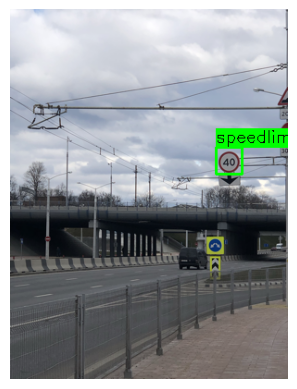

In [ ]:
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.show()